In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import matplotlib.pyplot as plt
import mols2grid
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# RDKit and chemistry-related tools
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, rdCoordGen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Descriptors import MoleculeDescriptors

IPythonConsole.ipython_useSVG = True

# Jupyter notebook magic
%matplotlib inline

# PyTorch and PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import BatchNorm1d, Dropout, GELU, Linear
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split

import torch_geometric
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    AttentiveFP,
    GATConv,
    GCNConv,
    GINConv,
    GlobalAttention,
    SAGEConv,
    TopKPooling,
    TransformerConv,
    global_max_pool,
    global_mean_pool
)
from torch_geometric.utils import from_smiles, to_networkx

# Scikit-learn metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    mean_squared_log_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    roc_curve
)

from sklearn.model_selection import KFold

In [2]:
# Set the seed value
random_seed = 50

# Ensure reproducibility across PyTorch (CPU & GPU)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# Ensure reproducibility for NumPy
np.random.seed(random_seed)

# Ensure deterministic behavior in PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
df = pd.read_csv("polymer_solubility_dataset.csv")
df.shape

(1818, 6)

In [4]:
df

,polymer,mono_name,mono_smiles,solvent,solvent_smiles,solvent_characteristic
0,Poly(acetylene),acetylene,C#C,aniline,Nc1ccccc1,1
1,Poly(acetylene),acetylene,C#C,acetone,CC(C)=O,0
2,Poly(acetylene),acetylene,C#C,Benzene,c1ccccc1,0
3,Poly(acetylene),acetylene,C#C,carbon tetrachloride,ClC(Cl)(Cl)Cl,0
4,Poly(acetylene),acetylene,C#C,cyclohexane,C1CCCCC1,0
...,...,...,...,...,...,...
1813,Poly(methylphenylsiloxane),methylphenylsiloxane,C[SiH](O[SiH3])c1ccccc1,diethyl ether,CCOCC,1
1814,Poly(methylphenylsiloxane),methylphenylsiloxane,C[SiH](O[SiH3])c1ccccc1,ethylene glycol,OCCO,0
1815,Poly(methylphenylsiloxane),methylphenylsiloxane,C[SiH](O[SiH3])c1ccccc1,chloroform,ClC(Cl)Cl,1
1816,Poly(methylphenylsiloxane),methylphenylsiloxane,C[SiH](O[SiH3])c1ccccc1,butanol,CCCCO,1


In [5]:
def calculate_descriptors(mol):
    if mol is None:
        return torch.zeros(1, 5, dtype=torch.float)
    
    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol)
    ]
    
    return torch.tensor(descriptors, dtype=torch.float).view(1, -1)

In [6]:
def get_edge_features(mol):
    bond_features = []
    edge_index = []

    bond_type_to_idx = {
        Chem.rdchem.BondType.SINGLE: 0,
        Chem.rdchem.BondType.DOUBLE: 1,
        Chem.rdchem.BondType.TRIPLE: 2,
        Chem.rdchem.BondType.AROMATIC: 3
    }

    num_bond_types = 4  # one-hot length

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # One-hot encode the bond type
        bond_type = bond_type_to_idx.get(bond.GetBondType(), -1)
        bond_type_one_hot = [0] * num_bond_types
        if 0 <= bond_type < num_bond_types:
            bond_type_one_hot[bond_type] = 1
        else:
            continue  # Skip unrecognized bond types

        # Additional boolean edge features
        extra_features = [
            float(bond.GetIsConjugated()),
            float(bond.IsInRing())
        ]

        features = bond_type_one_hot + extra_features

        # Add bidirectional edges
        edge_index += [[i, j], [j, i]]
        bond_features += [features, features]

    if len(edge_index) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, num_bond_types + 2), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, num_edges]
        edge_attr = torch.tensor(bond_features, dtype=torch.float)  # shape [num_edges, feature_dim]

    return edge_index, edge_attr

In [7]:
graph_list = []


for i, (smile1, smile2) in enumerate(zip(df['mono_smiles'], df['solvent_smiles'])):
    mol1 = Chem.MolFromSmiles(smile1)
    mol2 = Chem.MolFromSmiles(smile2)

    g1 = from_smiles(smile1)
    g2 = from_smiles(smile2)

    g1.x = g1.x.float()
    g2.x = g2.x.float()

    # Compute edge features
    g1.edge_index, g1.edge_attr = get_edge_features(mol1)
    g2.edge_index, g2.edge_attr = get_edge_features(mol2)

    # Compute descriptors
    descriptor_tensor1 = calculate_descriptors(mol1)
    descriptor_tensor2 = calculate_descriptors(mol2)

    y = torch.tensor(df['solvent_characteristic'][i], dtype=torch.float).view(1, -1)
    g1.y = y
    g2.y = y
    g1.descriptors = descriptor_tensor1
    g2.descriptors = descriptor_tensor2

    graph_list.append((g1, g2))

In [8]:
graph_list[0]

(Data(x=[2, 9], edge_index=[2, 2], edge_attr=[2, 6], smiles='C#C', y=[1, 1], descriptors=[1, 5]),
 Data(x=[7, 9], edge_index=[2, 14], edge_attr=[14, 6], smiles='Nc1ccccc1', y=[1, 1], descriptors=[1, 5]))

In [9]:
# Define the ratio for splitting the dataset (80% for training, 20% for validation)
train_ratio = 0.80

# Calculate the total number of samples in the dataset
dataset_size = len(graph_list)

# Calculate the number of samples for the training and validation sets
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Set a random seed for reproducibility
random_seed = 66
generator = torch.Generator().manual_seed(random_seed)

# Split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(graph_list, [train_size, val_size], generator=generator)

In [10]:
# Create the DataLoaders for the train and val sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [11]:
class SolubilityGNN(nn.Module):
    def __init__(self, hidden_channels, descriptor_size, dropout_rate):
        super(SolubilityGNN, self).__init__()

        # TransformerConv layers — include edge_dim to support edge_attr
        self.trans1 = TransformerConv(in_channels=9, out_channels=hidden_channels, heads=4, concat=True, edge_dim=6)
        self.bn1 = BatchNorm1d(hidden_channels * 4)

        self.trans2 = TransformerConv(in_channels=hidden_channels * 4, out_channels=hidden_channels, heads=4, concat=True, edge_dim=6)
        self.bn2 = BatchNorm1d(hidden_channels * 4)

        # GIN layer (does not use edge_attr)
        self.gin3 = GINConv(Linear(hidden_channels * 4, hidden_channels))
        self.bn3 = BatchNorm1d(hidden_channels)

        # Fully connected layers
        self.fc1 = Linear(hidden_channels * 4 + descriptor_size * 2, 128)
        self.fc2 = Linear(128, 64)
        self.fc3 = Linear(64, 32)
        self.out = Linear(32, 1)

        self.gelu = GELU()
        self.dropout = Dropout(p=dropout_rate)

    def gnn_block(self, x, edge_index, edge_attr):
        # Transformer layers with edge features
        x = self.gelu(self.bn1(self.trans1(x, edge_index, edge_attr)))
        x = self.dropout(x)

        x = self.gelu(self.bn2(self.trans2(x, edge_index, edge_attr)))
        x = self.dropout(x)

        # GINConv doesn't use edge_attr
        x = self.gelu(self.bn3(self.gin3(x, edge_index)))
        x = self.dropout(x)

        return x

    def forward(self, x1, edge_index1, batch_index1, descriptors1, edge_attr1,
                      x2, edge_index2, batch_index2, descriptors2, edge_attr2):

        # GNN block for molecule 1
        h1 = self.gnn_block(x1, edge_index1, edge_attr1)
        h1 = torch.cat([
            global_max_pool(h1, batch_index1),
            global_mean_pool(h1, batch_index1)
        ], dim=1)

        # GNN block for molecule 2
        h2 = self.gnn_block(x2, edge_index2, edge_attr2)
        h2 = torch.cat([
            global_max_pool(h2, batch_index2),
            global_mean_pool(h2, batch_index2)
        ], dim=1)

        # Combine pooled features with descriptors
        hybrid_features = torch.cat([h1, h2, descriptors1, descriptors2], dim=1)

        # Fully connected head
        x = self.gelu(self.fc1(hybrid_features))
        x = self.dropout(x)

        x = self.gelu(self.fc2(x))
        x = self.dropout(x)

        x = self.gelu(self.fc3(x))
        x = self.dropout(x)

        out = self.out(x)
        return out, hybrid_features

In [12]:
def train(train_loader):
    model.train()
    total_loss = total_samples = total_correct = 0
    y_true = []
    y_pred = []

    for data1, data2 in train_loader:
        data1 = data1.to(device)
        data2 = data2.to(device)
        
        optimizer.zero_grad()

        out, _ = model(data1.x, data1.edge_index, data1.batch, data1.descriptors, data1.edge_attr,
                       data2.x, data2.edge_index, data2.batch, data2.descriptors, data2.edge_attr)
        
        loss = F.binary_cross_entropy_with_logits(out.view(-1), data1.y.float().view(-1))
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * data1.num_graphs
        total_samples += data1.num_graphs

        y_true.append(data1.y.cpu().numpy())
        y_pred.append(torch.sigmoid(out).cpu().detach().numpy())

        pred = (torch.sigmoid(out) > 0.5).float()
        correct = (pred == data1.y).sum().item()
        total_correct += correct

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    auc = roc_auc_score(y_true, y_pred)
    accuracy = total_correct / total_samples * 100

    return auc, accuracy

In [13]:
@torch.no_grad()
def val(val_loader):
    model.eval()
    total_loss = total_samples = total_correct = 0
    y_true = []
    y_pred = []

    for data1, data2 in val_loader:
        data1 = data1.to(device)
        data2 = data2.to(device)

        out, _ = model(data1.x, data1.edge_index, data1.batch, data1.descriptors, data1.edge_attr,
                       data2.x, data2.edge_index, data2.batch, data2.descriptors, data2.edge_attr)
        
        loss = F.binary_cross_entropy_with_logits(out.view(-1), data1.y.float().view(-1))

        total_loss += float(loss) * data1.num_graphs
        total_samples += data1.num_graphs

        y_true.append(data1.y.cpu().numpy())
        y_pred.append(torch.sigmoid(out).cpu().detach().numpy())

        pred = (torch.sigmoid(out) > 0.5).float()
        correct = (pred == data1.y).sum().item()
        total_correct += correct

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    auc = roc_auc_score(y_true, y_pred)
    accuracy = total_correct / total_samples * 100

    return auc, accuracy

In [14]:
# Set up the device (GPU if available, otherwise CPU) and initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model with specified parameters and move it to the appropriate device
model = SolubilityGNN(hidden_channels=128, descriptor_size=5, dropout_rate=0.3).to(device)

# Set up the NAdam optimizer with learning rate and weight decay for regularization
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0006, weight_decay=0.0)

# Set up a Scheduler
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

In [15]:
# Ignore warnings (you might not need this, but keeping as per your original code)
warnings.filterwarnings("ignore", category=UserWarning)

# Initialize lists to store training and validation scores (AUC and accuracy)
score_train_auc = []
score_train_acc = []
score_val_auc = []
score_val_acc = []

epochs = 100

# Loop over each epoch for training
for epoch in range(epochs):
    
    # Train the model and get the training AUC and accuracy
    train_auc, train_accuracy = train(train_loader)

    # Adjust learning rate
    scheduler.step()

    # Validate the model and get the validation AUC and accuracy
    val_auc, val_accuracy = val(val_loader)

    # Append the AUC and accuracy to their respective lists
    score_train_auc.append(train_auc)
    score_train_acc.append(train_accuracy)
    score_val_auc.append(val_auc)
    score_val_acc.append(val_accuracy)

    # Print the progress of the training process (epoch number, AUC, and accuracy)
    print(f'Epoch: {epoch+1}/{epochs} | '
          f'AUC: {train_auc:.4f}, Accuracy: {train_accuracy:.2f}%, '
          f'Val AUC: {val_auc:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Epoch: 1/100 | AUC: 0.5963, Accuracy: 67.54%, Val AUC: 0.7370, Val Accuracy: 67.03%
Epoch: 2/100 | AUC: 0.7478, Accuracy: 72.63%, Val AUC: 0.7648, Val Accuracy: 76.92%
Epoch: 3/100 | AUC: 0.7816, Accuracy: 77.92%, Val AUC: 0.7997, Val Accuracy: 76.65%
Epoch: 4/100 | AUC: 0.7999, Accuracy: 78.95%, Val AUC: 0.7974, Val Accuracy: 76.65%
Epoch: 5/100 | AUC: 0.8032, Accuracy: 79.64%, Val AUC: 0.7913, Val Accuracy: 77.47%
Epoch: 6/100 | AUC: 0.8176, Accuracy: 79.85%, Val AUC: 0.8029, Val Accuracy: 76.65%
Epoch: 7/100 | AUC: 0.8383, Accuracy: 80.61%, Val AUC: 0.8095, Val Accuracy: 77.20%
Epoch: 8/100 | AUC: 0.8369, Accuracy: 80.67%, Val AUC: 0.8107, Val Accuracy: 76.10%
Epoch: 9/100 | AUC: 0.8451, Accuracy: 80.74%, Val AUC: 0.8181, Val Accuracy: 78.30%
Epoch: 10/100 | AUC: 0.8611, Accuracy: 80.95%, Val AUC: 0.8322, Val Accuracy: 77.47%
Epoch: 11/100 | AUC: 0.8738, Accuracy: 81.02%, Val AUC: 0.8322, Val Accuracy: 79.12%
Epoch: 12/100 | AUC: 0.8830, Accuracy: 82.19%, Val AUC: 0.8298, Val Accura

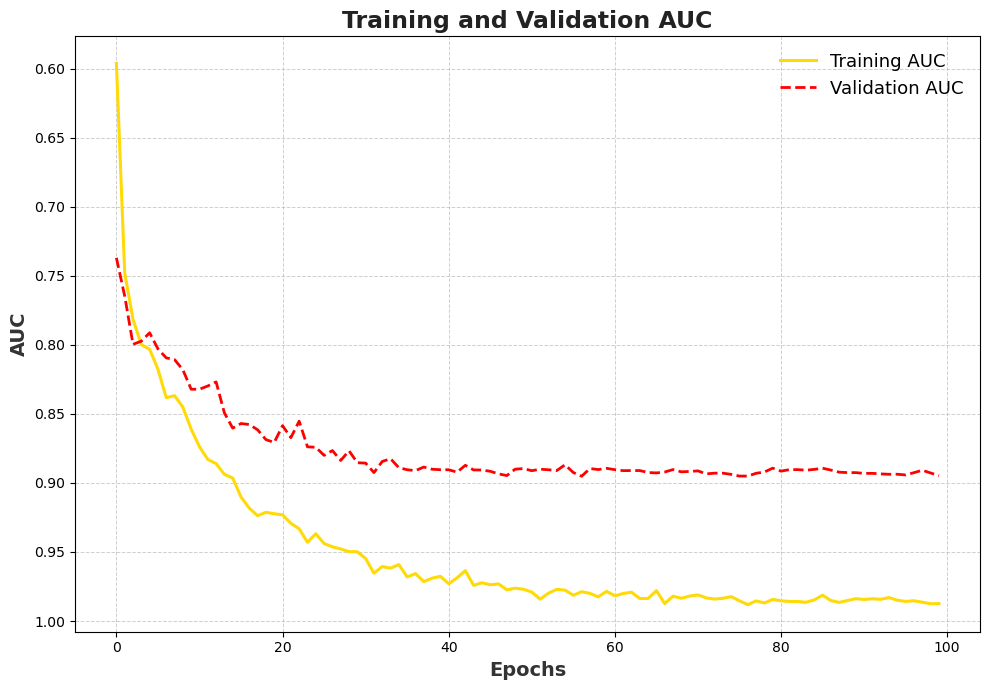

In [16]:
# Choose a style for the plot
plt.style.use("default")

# Create figure
plt.figure(figsize=(10, 7))

# Plot training and validation AUC with improved styling
plt.plot(range(epochs), score_train_auc, label='Training AUC', 
         color='#ffda06', linestyle='-', linewidth=2.2, alpha=1)

plt.plot(range(epochs), score_val_auc, label='Validation AUC', 
         color='red', linestyle='--', linewidth=2, alpha=1)

# Labels and title with a bold but clean look
plt.xlabel('Epochs', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('AUC', fontsize=14, fontweight='bold', color='#333333')
plt.title('Training and Validation AUC', fontsize=17, fontweight='bold', color='#222222')

# Flip the y-axis so that higher AUC values are at the top
plt.gca().invert_yaxis()

# Improve grid visibility but keep it subtle
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

# Improve legend (slightly larger, no border)
plt.legend(loc='upper right', fontsize=13, frameon=False)

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

In [17]:
# Cross-validation function
def run_cross_validation(graph_list, train_fn, val_fn, k_folds, n_epochs, batch_size, seed):
    warnings.filterwarnings("ignore", category=UserWarning)
    torch.manual_seed(seed)
    np.random.seed(seed)

    graph_list = list(graph_list)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

    # Initialize lists to store results for each fold
    train_auc_list, train_acc_list = [], []
    val_auc_list, val_acc_list = [], []

    print(f"\n=== Starting {k_folds}-Fold Cross-Validation ===")

    for fold, (train_idx, val_idx) in enumerate(kf.split(graph_list)):
        print(f"\n--- Fold {fold + 1}/{k_folds} ---")

        # Split the dataset into training and validation
        train_dataset = [graph_list[i] for i in train_idx]
        val_dataset = [graph_list[i] for i in val_idx]

        # Use the collate function from torch_geometric
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=Batch.from_data_list)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=Batch.from_data_list)


        # Define global variables for compatibility with your existing train/val/eval
        global model, optimizer, scheduler, device
        
        # Reset model, optimizer, and scheduler for each fold
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = SolubilityGNN(hidden_channels=128, descriptor_size=5, dropout_rate=0.3).to(device)
        optimizer = torch.optim.NAdam(model.parameters(), lr=0.0006, weight_decay=0.0)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

        # Train and evaluate for n_epochs
        for epoch in range(n_epochs):
            train_auc, train_acc = train_fn(train_loader)
            scheduler.step()
            val_auc, val_acc = val_fn(val_loader)

        # Store results for each fold
        train_auc_list.append(train_auc)
        train_acc_list.append(train_acc)
        val_auc_list.append(val_auc)
        val_acc_list.append(val_acc)

        print(f"Fold {fold+1} Results:")
        print(f"  Train AUC: {train_auc:.4f} | Train Accuracy: {train_acc:.2f}%")
        print(f"  Val AUC: {val_auc:.4f} | Val Accuracy: {val_acc:.2f}%")

    # Summary function
    def summary(metric_list, name):
        mean = np.mean(metric_list)
        std = np.std(metric_list)
        return f"{name}: {mean:.4f} ± {std:.4f}"

    # Print overall cross-validation results
    print("\n=== Cross-Validation Summary ===")
    print(summary(train_auc_list, "Train AUC"))
    print(summary(train_acc_list, "Train Accuracy"))
    print(summary(val_auc_list, "Val AUC"))
    print(summary(val_acc_list, "Val Accuracy"))

In [18]:
@torch.no_grad()
def eval(loader):
    output = []  # Store model predictions and true values
    smi = []     # Store SMILES strings
    model.eval()

    for data1, data2 in loader:
        data1 = data1.to(device)
        data2 = data2.to(device)

        out, _ = model(data1.x, data1.edge_index, data1.batch, data1.descriptors, data1.edge_attr,
                       data2.x, data2.edge_index, data2.batch, data2.descriptors, data2.edge_attr)

        prob = torch.sigmoid(out).squeeze()
        preds = (prob > 0.5).long()

        concatenated_data = torch.cat((preds.view(-1, 1), data1.y.view(-1, 1)), dim=1)
        output.append(concatenated_data)

        smi.extend(data1.smiles)

    stacked_output = torch.cat(output, dim=0).cpu().numpy()
    stacked_smiles = np.array(smi)

    results = pd.DataFrame(stacked_output, columns=['pred', 'actual'])
    results['smiles'] = stacked_smiles

    return results

In [19]:
def evaluate_preds(y_true, y_preds):
    # Calculate metrics for binary classification
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    # Print the metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

    # Return rounded metrics
    return {"Accuracy": round(accuracy, 3), 
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1 Score": round(f1, 3)}

In [20]:
# Evaluate the model on validation data
val_res = eval(val_loader)

# Evaluate predictions and true values
evaluate_preds(val_res['actual'], val_res['pred']);

Accuracy: 0.835
Precision: 0.893
Recall: 0.857
F1 Score: 0.874


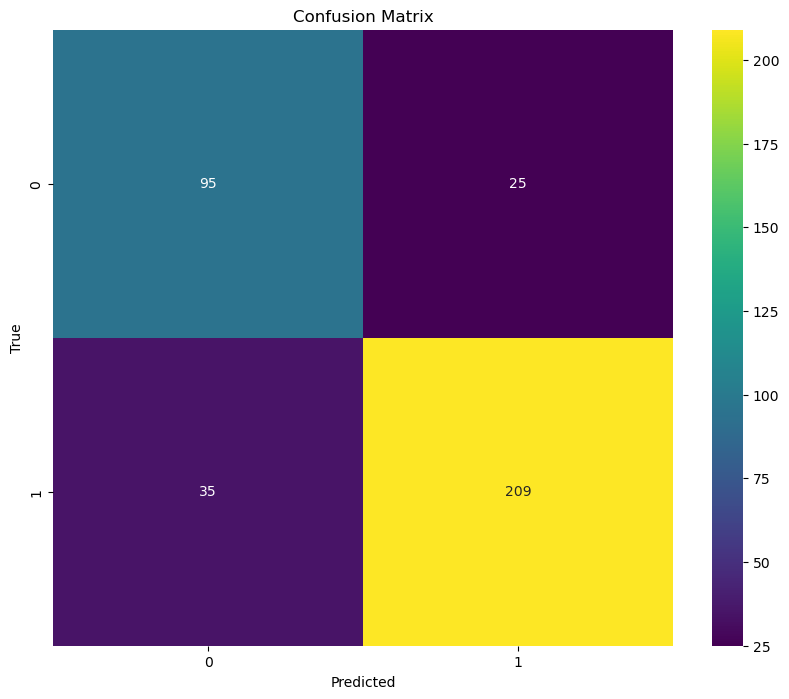

In [21]:
# Calculate confusion matrix
ConfusionMatrix = confusion_matrix(val_res['actual'], val_res['pred'])

# Plot confusion matrix with custom formatting
plt.figure(figsize=(10, 8))

# Use the 'fmt' argument to set the format for annotations
sns.heatmap(ConfusionMatrix, cmap="viridis", annot=True, fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [22]:
run_cross_validation(
    graph_list=graph_list,
    train_fn=train,
    val_fn=val,
    k_folds=5,
    n_epochs=100,
    batch_size=64,
    seed=random_seed
)


=== Starting 5-Fold Cross-Validation ===

--- Fold 1/5 ---
Fold 1 Results:
  Train AUC: 0.9853 | Train Accuracy: 93.33%
  Val AUC: 0.8550 | Val Accuracy: 82.42%

--- Fold 2/5 ---
Fold 2 Results:
  Train AUC: 0.9854 | Train Accuracy: 94.09%
  Val AUC: 0.9088 | Val Accuracy: 84.89%

--- Fold 3/5 ---
Fold 3 Results:
  Train AUC: 0.9807 | Train Accuracy: 92.98%
  Val AUC: 0.8740 | Val Accuracy: 79.12%

--- Fold 4/5 ---
Fold 4 Results:
  Train AUC: 0.9806 | Train Accuracy: 93.20%
  Val AUC: 0.8774 | Val Accuracy: 83.20%

--- Fold 5/5 ---
Fold 5 Results:
  Train AUC: 0.9846 | Train Accuracy: 94.43%
  Val AUC: 0.8744 | Val Accuracy: 80.72%

=== Cross-Validation Summary ===
Train AUC: 0.9833 ± 0.0022
Train Accuracy: 93.6056 ± 0.5558
Val AUC: 0.8779 ± 0.0174
Val Accuracy: 82.0681 ± 1.9935


In [23]:
# Save the trained model
torch.save(model.state_dict(), "solubility_gnn.pt")
print("Model saved to solubility_gnn.pt")

Model saved to solubility_gnn.pt
